# Importing Libraries

In [1]:
# Installing required additional modules
!pip install tqdm
# Importing required modules
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from keras import backend as k
import keras
import matplotlib.pyplot as plt
from keras.initializers import *
import os
import cv2
import numpy as np
import pickle
import concurrent.futures
from tqdm import tqdm
import random
import warnings

# Downloading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/My Drive/Celeb/CelebAMask-HQ.zip"

Streaming output truncated to the last 5000 lines.
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_neck.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_nose.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_r_brow.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_r_eye.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_skin.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_u_lip.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_hair.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_brow.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_eye.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_lip.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_mouth.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_neck.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_nose.png  
  inflating: CelebAMask-HQ/Cel

# Pre-Processing Mask

In [2]:
image_base = "CelebAMask-HQ/CelebA-HQ-img/"
ann_base = "CelebAMask-HQ/CelebAMask-HQ-mask-anno/"
NO_OF_CHUNKS = 2
CHUNK_SIZE = 100
IN_HEIGHT = 224
IN_WIDTH = 224
IN_CHANNELS_MASK = 1 #channels of mask
IN_CHANNELS_IM = 3  #channels of image

The following code will perform the pre-processing of the mask.

I am using only 200 images to train the model, as the large dataset is going to take more time to take as a result I am using 200 images.

Also I am resizing the image to 224*224, for easy computation.



In [14]:
def fuse_masks(u_lip, l_lip, r_eye, l_eye):
        ''' Takes upper_lip, lower_lip, right_eye, and left_eye masks and fuses them to create a single mask.'''
        # If any of the mask is absent, replaces it with a black mask
        if(u_lip is None):
            u_lip = np.zeros((512, 512), dtype = np.uint8)
        if(l_lip is None):
            l_lip = np.zeros((512, 512), dtype = np.uint8)
        if(r_eye is None):
            r_eye = np.zeros((512, 512), dtype = np.uint8)
        if(l_eye is None):
            l_eye = np.zeros((512, 512), dtype = np.uint8)
        
        lips = np.add(u_lip, l_lip) # fuses both the lip masks
        eyes = np.add(r_eye, l_eye) # fuses both the eye masks
        final_mask = np.add(lips, eyes) # fuses eyes and lips 
        return final_mask

def pre_process_masks_helper(image):
        '''Opens all the four masks, passes them to the fuse_masks function and finally resizes the returned image to 224*224.'''
        temp = image.split('.')[0]
        folder_count = int(int(temp) / 2000) # determines the folder in which the masks are located.
        temp = temp.zfill(5) # pads the filename with zeros to the left.
        ann_u_lip_file = temp + "_u_lip.png"
        ann_l_lip_file = temp + "_l_lip.png"
        ann_l_eye_file = temp + "_l_eye.png"
        ann_r_eye_file = temp + "_r_eye.png"
        u_lip_img = cv2.imread(ann_base + str(folder_count) + "/" + ann_u_lip_file, cv2.IMREAD_GRAYSCALE)
        l_lip_img = cv2.imread(ann_base + str(folder_count) + "/" + ann_l_lip_file, cv2.IMREAD_GRAYSCALE)
        l_eye_img = cv2.imread(ann_base + str(folder_count) + "/" + ann_l_eye_file, cv2.IMREAD_GRAYSCALE)
        r_eye_img = cv2.imread(ann_base + str(folder_count) + "/" + ann_r_eye_file, cv2.IMREAD_GRAYSCALE)
        t = fuse_masks(u_lip_img, l_lip_img, r_eye_img, l_eye_img)
        del u_lip_img
        del l_lip_img
        del l_eye_img
        del r_eye_img
        t = cv2.resize(t, (IN_HEIGHT, IN_WIDTH))
        t = t.astype('float32')
        t = (t - 127.5) / 127.5 # converts the image in the range [-1, 1]
        return t

def pre_process_masks():
        ''' This is a parallelised code, where the image list is shared among different cores of CPU for performing pre_process_masks_helper function'''
        images_list = os.listdir(image_base) # contains all the image file names
        images_list.sort()
        # Checks if numpy arrays are already created or not.
        if(os.path.exists('masks_0.npy')):
            return
        # iterates NO_OF_CHUNKS times on CHUNK_SIZE images
        for i in range(NO_OF_CHUNKS):
            masks = []
            image_list = images_list[CHUNK_SIZE*i : CHUNK_SIZE + CHUNK_SIZE*i]
            with concurrent.futures.ProcessPoolExecutor() as executor: # creates a process pooler 
                for image, mask in zip(image_list, executor.map(pre_process_masks_helper, image_list)): # shares the list among different cores of CPU
                    masks.append(mask)
                        
            masks = np.array(masks, dtype = np.float32)
            # Saves the masks numpy array on to the drive
            with open("masks_" + str(i) +".npy",'wb') as pickle_file:
                pickle.dump(masks,pickle_file,pickle.HIGHEST_PROTOCOL)
            print("Processed and saved " + str(CHUNK_SIZE + i*CHUNK_SIZE) + " images")
            del masks
        print("Masks saved successfully!")

The data is preprocessing in the form of chunks. Chunks of data will enable to improve the performance and to avoid memory related problems.

In [6]:
pre_process_masks()

Processed and saved 100 images
Processed and saved 200 images
Masks saved successfully!


# Preprocessing Image

In [12]:
    def resize_image(image):
        ''' Takes in an image, opens it, resizes it, and coverts it into the range [-1, 1]. '''
        t = cv2.imread(image_base + image)
        t = cv2.resize(t, (IN_HEIGHT, IN_WIDTH))
        t = (t - 127.5) / 127.5
        return t

    def pre_process_images():
        ''' This is a parallelised code, where the image list is shared among different cores of CPU for performing resize_image function'''
        images_list = os.listdir(image_base) # contains all the image file names
        images_list.sort()
        i = 0
        # Checks if numpy arrays are already created or not.
        if(os.path.exists('images_0.npy')):
            return
        # iterates NO_OF_CHUNKS times on CHUNK_SIZE images
        for i in range(NO_OF_CHUNKS):
            images = []
            image_list = images_list[CHUNK_SIZE*i :CHUNK_SIZE + CHUNK_SIZE*i]
            with concurrent.futures.ProcessPoolExecutor() as executor: # creates a process pooler   
                for image, mask in zip(image_list, executor.map(resize_image, image_list)): # shares the list among different cores of CPU
                    images.append(mask)

            images = np.array(images, dtype = np.float32)
            # Saves the images numpy array on to the drive
            with open("images_" + str(i) +".npy",'wb') as pickle_file:
                pickle.dump(images,pickle_file,pickle.HIGHEST_PROTOCOL)
            print("Processed and saved "+ str(CHUNK_SIZE + i*CHUNK_SIZE) + " images")
            del images
        print("Images saved successfully!")

In [8]:
pre_process_images()

Processed and saved 100 images
Processed and saved 200 images
Images saved successfully!


# Loading Images and Mask

In [3]:
    def load_images():
        ''' Loads the images saved on the drive as npy to the main memory.'''
        temp = []
        for i in range(NO_OF_CHUNKS):
            with open("images_" + str(i) +".npy",'rb') as pickle_file:
                imgs = pickle.load(pickle_file)
                temp.append(imgs)
                del imgs
        images = np.concatenate((temp[0], temp[1]), axis=0)
        print("Images Loaded successfully!")
        return images
        
    
    def load_masks():
        ''' Loads the masks saved on the drive as npy to the main memory.'''
        temp = []
        for i in range(NO_OF_CHUNKS):
            with open("masks_" + str(i) +".npy",'rb') as pickle_file:
                imgs = pickle.load(pickle_file)
                temp.append(imgs)
                del imgs
        masks = np.concatenate((temp[0], temp[1]), axis=0)
        masks = masks.reshape((NO_OF_CHUNKS*CHUNK_SIZE, IN_HEIGHT, IN_WIDTH, IN_CHANNELS_MASK))
        print("Masks loaded successfully!")
        return masks
        

In [4]:
images = load_images()
masks = load_masks()

Images Loaded successfully!
Masks loaded successfully!


# Creating Model

U-net model is implemented with input dimension (224, 224, 3). The inital weight are intialized according to normal distribution. This allow the model to learn quickly.

In [15]:
        input_size=(IN_HEIGHT, IN_WIDTH, IN_CHANNELS_IM)
        inputs = Input(input_size, name='image_input')
        init = RandomNormal(mean=0.0, stddev=0.02)
        conv1 = Conv2D(32, 3, strides = (2,2), padding='same', kernel_initializer=init, name='aen_conv1')(inputs)
        bn1 = BatchNormalization(momentum = 0.8)(conv1)
        lr1 = LeakyReLU(0.2)(bn1)
        
        conv2 = Conv2D(64, 3, strides = (2,2), padding='same', kernel_initializer=init, name='aen_conv2')(lr1)
        bn2 = BatchNormalization(momentum = 0.8)(conv2)
        lr2 = LeakyReLU(0.2)(bn2)
        
        conv3 = Conv2D(128 , 3, strides = (2,2), padding='same', kernel_initializer=init, name='aen_conv3')(lr2)
        bn3 = BatchNormalization(momentum = 0.8)(conv3)
        lr3 = LeakyReLU(0.2)(bn3)
        
        conv4 = Conv2D(256, 3, strides = (2,2), padding='same', kernel_initializer=init, name='aen_conv4')(lr3)
        bn4 = BatchNormalization(momentum = 0.8)(conv4)
        lr4 = LeakyReLU(0.2)(bn4)
        drop4 = Dropout(0.5)(lr4)

        conv5 = Conv2D(128, 3, padding = 'same', kernel_initializer = init, name = 'aen_conv5')(UpSampling2D(size=(2, 2))(drop4))
        bn5 = BatchNormalization(momentum = 0.8)(conv5)
        lr5 = LeakyReLU(0.2)(bn5)
        merge5 = concatenate([lr3, lr5], axis=3)
        conv6 = Conv2D(128, 3, padding='same', kernel_initializer=init, name='aen_conv6')(merge5)
        bn6 = BatchNormalization(momentum = 0.8)(conv6)
        lr6 = LeakyReLU(0.2)(bn6)

        conv7 = Conv2D(64, 3, padding = 'same', kernel_initializer = init, name ='aen_conv7') (UpSampling2D(size=(2, 2))(lr6))
        bn7 = BatchNormalization(momentum = 0.8)(conv7)
        lr7 = LeakyReLU(0.2)(bn7)
        merge6 = concatenate([lr2, lr7], axis=3)
        conv8 = Conv2D(64, 3, padding='same', kernel_initializer=init, name='aen_conv8')(merge6)
        bn8 = BatchNormalization(momentum = 0.8)(conv8)
        lr8 = LeakyReLU(0.2)(bn8)

        conv9 = Conv2D(32, 3, padding='same', kernel_initializer = init, name = 'aen_conv9') (UpSampling2D(size=(2, 2))(lr8))
        bn9 = BatchNormalization(momentum = 0.8)(conv9)
        lr9 = LeakyReLU(0.2)(bn9)
        merge7 = concatenate([lr1, lr9], axis=3)

        up11 = UpSampling2D(size=(2,2))(merge7)
        conv10 = Conv2D(1, 3, activation = 'tanh', padding='same', kernel_initializer= init, name='aen_out')(up11)

        model = Model([inputs], [conv10] , name= 'autoencoder')

For the last layer I have used tanh activation function. Tanh function gives better training performance for multi-layer neural networks. It also produces zero centred output thereby aiding the back-propagation process. 

In [16]:
    def custom_loss(y_true, y_pred):
        ''' This is the custom_loss function which model tries to optimise. It is the pixel-wise mean squared error''' 
        loss = k.mean(k.square(y_true - y_pred), axis=-1)
        return loss

Here I have used pixel-wise mean squared error. The pixel-wide MSE loss calculates how different the generated images are from the real images. It calculates between each pixel value from the real image and each pixel value from the generated image.

Binary Cross entropy and soft dice loss can be used as evaluation metrics.

In [17]:
        aen = model
        aen.compile(optimizer = Adam(lr=1e-4), loss=custom_loss, metrics = ['accuracy'] )
        print(aen.summary())

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
aen_conv1 (Conv2D)              (None, 112, 112, 32) 896         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 112, 112, 32) 128         aen_conv1[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 112, 112, 32) 0           batch_normalization_9[0][0]      
________________________________________________________________________________________

# Training and saving model

In [18]:
EPOCHS = 100
BATCH_SIZE = 64

In [19]:
aen.fit(x=images, y=masks, batch_size=BATCH_SIZE, validation_split=0.2, epochs=EPOCHS)

Epoch 1/100
3/3 [==============================] - 54s 16s/step - loss: 1.0273 - accuracy: 4.4781e-04 - val_loss: 0.9675 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 51s 16s/step - loss: 0.8071 - accuracy: 6.3417e-05 - val_loss: 0.9508 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 51s 16s/step - loss: 0.6850 - accuracy: 5.9595e-05 - val_loss: 0.8797 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 51s 16s/step - loss: 0.5849 - accuracy: 3.6247e-05 - val_loss: 0.7561 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 51s 16s/step - loss: 0.4970 - accuracy: 9.1397e-06 - val_loss: 0.5840 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 51s 16s/step - loss: 0.4265 - accuracy: 1.4947e-06 - val_loss: 0.4503 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 51s 16s/step - loss: 0.3697 - accuracy: 1.0977e-06 - val_loss

In [20]:
aen.save('aen_model.h5') # Saves the model after training

# Visualizing results

In [21]:
    def thresholding(gen_img):
        ''' Binarizes the generated image to whites and blacks with 127 as threshold.'''
        gen_img = gen_img.reshape(IN_HEIGHT, IN_WIDTH)
        ret, thresh = cv2.threshold(gen_img,127,255,cv2.THRESH_BINARY_INV)
        return thresh

    def convert(gen_img):
        ''' Converts the binary one channel image to RGB image with blacks and whites alone.'''
        black = np.array([0,0,0], dtype = np.uint8)
        white = np.array([255,255,255], dtype = np.uint8)
        t = np.zeros((gen_img.shape[0], gen_img.shape[1], 3), dtype = np.uint8)
        for i in range(gen_img.shape[0]):
            for j in range(gen_img.shape[1]):
                if(gen_img[i][j] == 255):
                    t[i][j] = black
                if(gen_img[i][j] == 0):
                    t[i][j] = white
        return t

    def fix( image, aen):
        ''' Takes in an image, predicts the mask based on the model, binarizes the image and finally converts it into a RGB image.'''
        img = cv2.resize(image, (IN_HEIGHT, IN_WIDTH), interpolation = cv2.INTER_CUBIC)
        img = img.reshape(1, IN_HEIGHT, IN_WIDTH, IN_CHANNELS_IM)
        gen_img = aen.predict(img)
        gen_img = gen_img*0.5 + 0.5
        gen_img = gen_img*255
        gen_img = gen_img.astype(np.uint8)
        thresh = thresholding(gen_img)
        gen_img = convert(thresh)
        gen_img = gen_img.reshape(IN_HEIGHT, IN_WIDTH, IN_CHANNELS_IM)
        gen_img = cv2.resize(gen_img, (250, 250), interpolation = cv2.INTER_CUBIC)
        gen_img = gen_img.astype(np.uint8)
        return gen_img
    
    def visualise_results():
        ''' This function shows the model results after training. It takes 5 random images, predicts the RGB mask for it and overlays the mask on the original image.'''
        NUM_DISPLAY = 5
        images_list = os.listdir(image_base)
        images_list.sort()
        files = images_list[10000:]

        grid = []
        aen = load_model('aen_model.h5', custom_objects={'custom_loss': custom_loss})
        for path in random.sample(files, NUM_DISPLAY):
            im = resize_image(path)
            fixed = fix(im, aen)
            im = cv2.resize(im,(250,250))
            im = im*0.5 + 0.5
            im = im*255
            im = im.astype(np.uint8)
            final = cv2.addWeighted(im, 0.5, fixed, 0.5, 0.0)
            grid.append(np.column_stack([im, fixed, final]))

        # In the output image, the first column is the input image, the second column is the predicted mask of the image, 
        # and the third column is acquired after overlaying the mask on the image
        image = np.row_stack(grid)
        dpi = float(plt.rcParams['figure.dpi'])
        figsize = image.shape[1] / dpi, image.shape[0] / dpi
        ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
        ax.axis('off')
        ax.imshow(image[..., ::-1])
        plt.show()

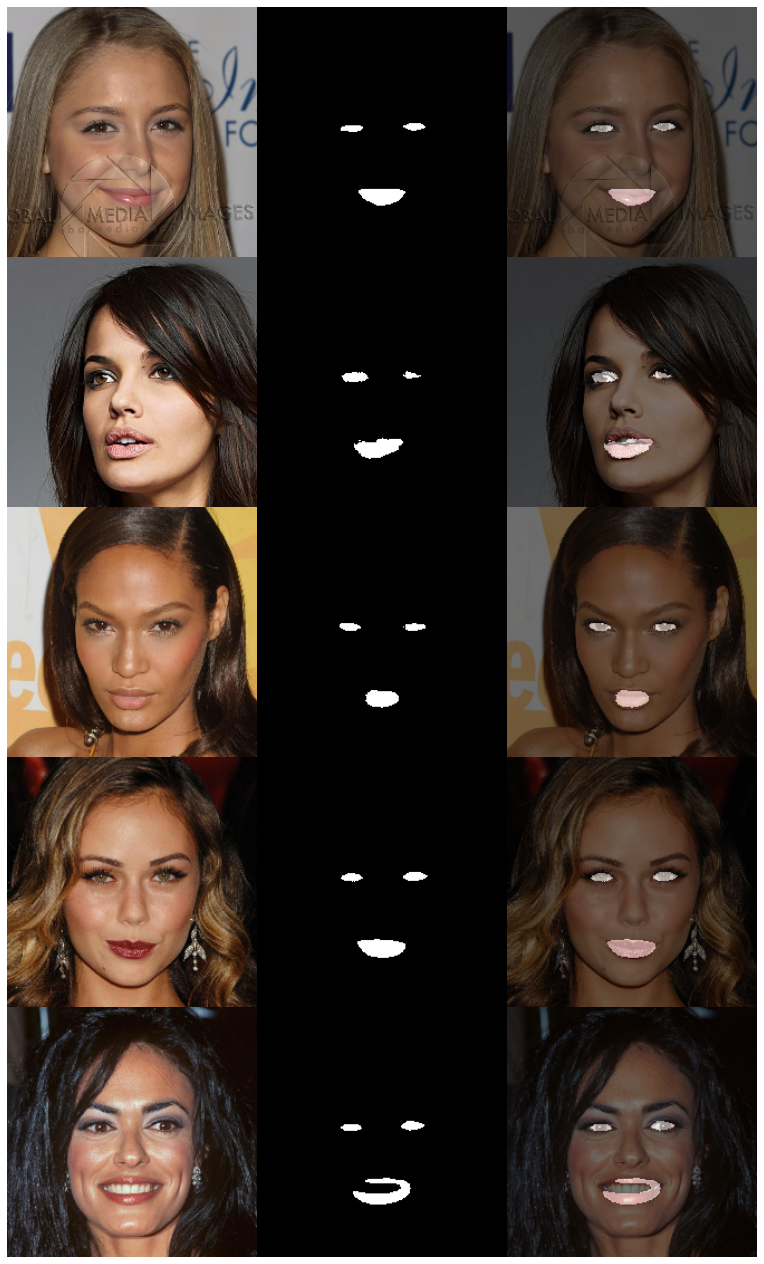

In [22]:
visualise_results()